## Skill Centrality in a Job Posting
***
The goal of this workflow document is to show one way of establishing a relationship between skills in a given document and understanding which skills could be considered as "central" to the document's importance, given its relationship with the surrounding skills.
***

In [1]:
# import our libraries first
import networkx as nx
import pandas as pd

from EmsiApiPy import SkillsClassificationConnection

conn = SkillsClassificationConnection()

***
The first thing we do is extract the skills from the given text. This is a job posting from Emsi's history for a Full Stack Web Developer. We'll identify the skills that are core to this role.

In [2]:
# extract skills from the Emsi skills library
text = """
Full Stack Web Developer
Emsi is a trusted advisor on labor market information for customers across a wide array of markets. We build SaaS products that combine many different kinds of workforce data to accurately inform our clients’ decisions about college course offerings, hiring, site selection, economic development, and much more. We need an experienced developer to join us in producing premier software tools for understanding labor market data.

If you’re ready to join a high-functioning team of full stack devs working closely with product managers, data engineers, and designers to create interfaces and visualizations that make nuanced data intelligible, we’d love to hear from you.
Candidates must have…

    Experience with the front-end basics: HTML5, CSS3, and JS
    Experience using a version control system
    Familiarity with MV* frameworks, e.g. React, Ember, Angular, Vue
    Familiarity with server-side languages like PHP, Python, or Node

Great candidates also have…

    Experience with a particular JS MV* framework (we happen to use React)
    Experience working with databases
    Experience with AWS
    Familiarity with microservice architecture
    Familiarity with modern CSS practices, e.g. LESS, SASS, CSS-in-JS

People who succeed in this position are…

    Team oriented and ready to work closely with other developers
    Determined to produce clean, well-tested code
    Comfortable with working in rapid development cycles
    Skilled oral and written communicators
    Enthusiastic for learning and pushing the envelope

Emsi is an equal opportunity employer.
"""

response = conn.post_extract(text)

# save the skills into lists for later
skill_ids = [record["skill"]["id"] for record in response["data"]]
skill_names = [record["skill"]["name"] for record in response["data"]]

print(skill_names)

['Server-Side', 'Economic Development', 'Enthusiasm', 'React.js', 'Cascading Style Sheets (CSS)', 'PHP (Scripting Language)', 'Python (Programming Language)', 'Full Stack Software Engineering', 'Angular (Web Framework)', 'Version Control', 'Vue.js', 'Node.Js', 'Microservices', 'Ember.Js', 'Amazon Web Services', 'HTML5', 'Team Oriented', 'Site Selection', 'Front End (Software Engineering)', 'JavaScript (Programming Language)', 'Software as a Service (SaaS)']


In [3]:
# from here, we define the relationships between each core skill (index) and each other skill from our extracted list
relationships = {}

for index in range(len(skill_ids)):
    related = conn.post_find_related_skills([skill_ids[index]], limit = 5, fields = ["name", "id"])
    keep = [record["name"] for record in related["data"] if record["id"] in skill_ids]
    
    relationships[index] = [skill_names.index(record) for record in keep]

relationships

{0: [18],
 1: [],
 2: [],
 3: [8, 18, 19, 11, 10],
 4: [18, 15, 19],
 5: [19],
 6: [14],
 7: [8, 19, 11, 3],
 8: [4, 18, 19, 11, 3],
 9: [0],
 10: [8, 18, 19, 3],
 11: [8, 4, 7, 19, 3],
 12: [14],
 13: [8],
 14: [6],
 15: [8, 4, 19],
 16: [],
 17: [],
 18: [8, 4, 19, 3],
 19: [8, 4, 18, 3],
 20: []}

***
You can see in the above how the different points are related and there are four skills that are not related to the other skills at all. We'll get rid of those in a moment. First, we'll show a chart of all the skills.

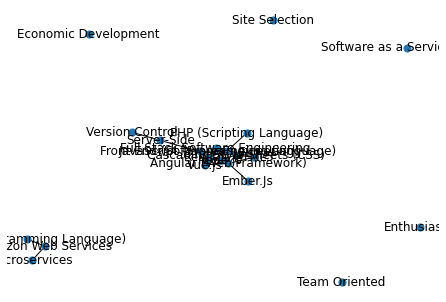

In [4]:
# create a graph of all the fields and their relationships
graph = nx.Graph(relationships)
graph = nx.relabel_nodes(graph, {index: skill_names[index] for index in relationships.keys()})
nx.draw(graph, with_labels = True, node_size = 50)

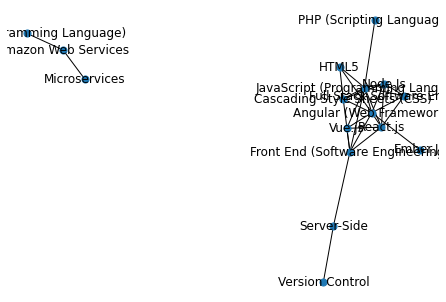

In [5]:
# remove the isolated nodes from the graph (anything not related to other skills)
graph.remove_nodes_from(list(nx.isolates(graph)))
nx.draw(graph, with_labels = True, node_size = 50)

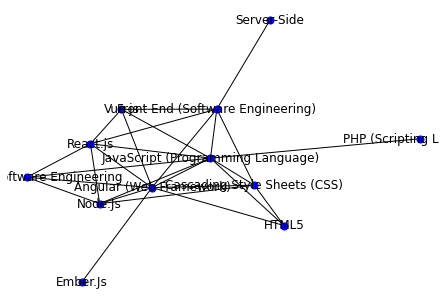

In [6]:
# get the central point of the main hub of the chart and graph the skills within two steps around it
from operator import itemgetter

# gets all the nodes in the graph and how connected they are
node_and_degree = graph.degree()

# isolates the largest one from the graph
largest_hub, degree = sorted(node_and_degree, key=itemgetter(1))[-1]

# create a graph isolated to the largest hub and any skill that is 2 steps away
# you could also consider oonly using one step away, if you want to limit the number of skills coming back
hub_ego = nx.ego_graph(graph, largest_hub, radius = 2)
pos = nx.spring_layout(hub_ego)

nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True)

From the chart here, we can see that Angular is central to the group of skills, given its relationship with everything else around it. 
***
However, we might have other skills that are equally important to this grouping of skills, if we consider this from a degree-centrality perspective:

In [7]:
nx.degree_centrality(hub_ego)

{'Server-Side': 0.09090909090909091,
 'React.js': 0.5454545454545454,
 'Cascading Style Sheets (CSS)': 0.4545454545454546,
 'PHP (Scripting Language)': 0.09090909090909091,
 'Full Stack Software Engineering': 0.36363636363636365,
 'Angular (Web Framework)': 0.8181818181818182,
 'Vue.js': 0.36363636363636365,
 'Node.Js': 0.4545454545454546,
 'Ember.Js': 0.09090909090909091,
 'HTML5': 0.2727272727272727,
 'Front End (Software Engineering)': 0.5454545454545454,
 'JavaScript (Programming Language)': 0.8181818181818182}

And we can see here that JavaScript and Angular have the same degree centrality to this graph.